In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

심층신경망을 훈련하는 것은 여러 문제에 직면할 수 있음
- Gradient Vanishing or Gradient Exploding
- 대규모 신경망의 훈련에 부족한 데이터
- 훈련속도가 느려질 수 있음
- 수백만개의 파라미터를 가진 모델은 과대적합 우려.

# 11.1 Gradient 소실과 폭주 문제

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

그림 저장: sigmoid_saturation_plot


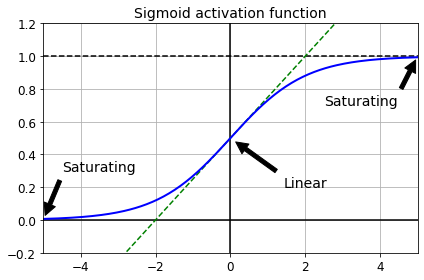

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

시그모이드 함수의 경우 입력이 양수나 음수로 커지면 기울기가 0에 가까워지기 때문에, Gradient Vanishing 문제가 발생한다

## 11.1.1 Xavier과 He 초기화

### 자비에 초기화

$fan_{avg} = (fan_{in} + fan_{out})/2$, 평균이  0이고  분산이 ${1 \over fan_{avg}}$ 을 이용해서 각 층의 연결 가중치를 무작위 초기화

### He 초기화

분산이 ${2 \over {fan_{in}}}$ 인 ReLU함수

### 로쿤 초기화

분산이 ${1 \over fan_{in}}$ 인 SELU 함수

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

In [6]:
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

## 11.1.2 수렴하지 않는 활성화 함수

ReLU는 죽은 ReLU(훈련하는 동안 일부 뉴런이 0만 출력) 문제 발생

이 문제를 해결하기 위해 LeakyReLU와 같은 ReLU 함수의 변종을 사용

### LeakyReLU

$LeakyReLU_a(z) = max(az, z)$ 하이퍼파리미터 a가 함수가 새는 정도를 결정.

새는 정도란 z < 0일 때 이 함수의 기울기이며, 일반적으로 0.01로 설정

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

그림 저장: leaky_relu_plot


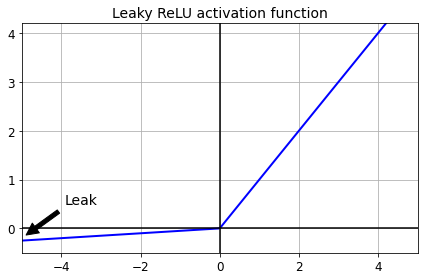

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(10, activation='softmax')
])

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 1.3122 - accuracy: 0.6186 - val_loss: 0.9047 - val_accuracy: 0.7158
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8059 - accuracy: 0.7345 - val_loss: 0.7203 - val_accuracy: 0.7636
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6870 - accuracy: 0.7706 - val_loss: 0.6475 - val_accuracy: 0.7886
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6249 - accuracy: 0.7932 - val_loss: 0.5924 - val_accuracy: 0.8072
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5849 - accuracy: 0.8068 - val_loss: 0.5597 - val_accuracy: 0.8194
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5564 - accuracy: 0.8152 - val_loss: 0.5361 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5347 - accuracy: 0.8219 - val_loss: 0.5166 - val_accuracy:

### PReLU

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [19]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [20]:
model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8197 - accuracy: 0.7356 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6004 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5618 - accuracy: 0.8136 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU

In [21]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


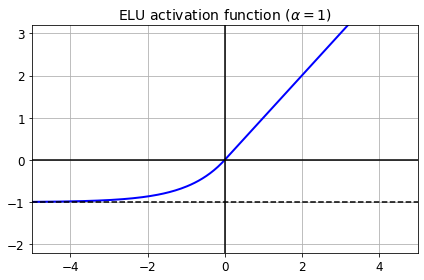

In [22]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

In [23]:
keras.layers.Dense(10, activation='elu')

### SELU

SELU는 각 층의 평균과 표준편차를 보존하려는 성질이 있어 Gradient Vanishing이나 Exploding 문제를 해결

In [24]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [25]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

그림 저장: selu_plot


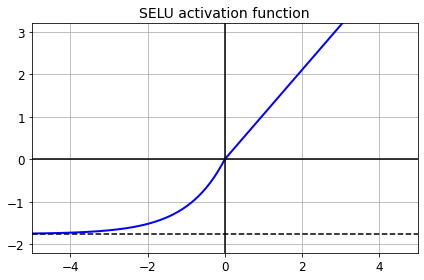

In [26]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [27]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [28]:
# SELU를 사용하려면 activation='selu'와 커널 initializer도 함께 지정
keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

In [29]:
np.random.seed(42)
tf.random.set_seed(42)

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [32]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [33]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 24s 12ms/step - loss: 1.2478 - accuracy: 0.5192 - val_loss: 0.8615 - val_accuracy: 0.6900
Epoch 2/5
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8080 - accuracy: 0.7036 - val_loss: 0.7511 - val_accuracy: 0.7176
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.7182 - accuracy: 0.7350 - val_loss: 0.6794 - val_accuracy: 0.7212
Epoch 4/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6261 - accuracy: 0.7664 - val_loss: 0.6760 - val_accuracy: 0.7542
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6271 - accuracy: 0.7684 - val_loss: 0.5441 - val_accuracy: 0.8060


SELU 대신 ReLU를 사용하였을 때의 문제점

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [36]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [37]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 20s 10ms/step - loss: 1.7794 - accuracy: 0.2716 - val_loss: 1.2705 - val_accuracy: 0.4322
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 1.1789 - accuracy: 0.5002 - val_loss: 0.9865 - val_accuracy: 0.5870
Epoch 3/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.9296 - accuracy: 0.6193 - val_loss: 0.8785 - val_accuracy: 0.6502
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.8235 - accuracy: 0.6734 - val_loss: 0.7385 - val_accuracy: 0.6938
Epoch 5/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.7650 - accuracy: 0.7050 - val_loss: 0.8442 - val_accuracy: 0.6726


성능이 좋지않음 -> 기울기 소실 또는 폭주 현상이 나타난 것

## 11.1.3 배치 정규화

훈련하는 동안 입력을 정규화한 다음 스케일을 조정하고 이동

첫 입력층에 배치정규화를 진행할 경우 데이터를 StandardScaler로 표준화 해줄 필요가 없다

In [39]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [41]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [43]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3),
             metrics=['accuracy'])

In [44]:
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.9021 - accuracy: 0.6946 - val_loss: 0.6012 - val_accuracy: 0.8004
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6103 - accuracy: 0.7904 - val_loss: 0.5175 - val_accuracy: 0.8240
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5540 - accuracy: 0.8078 - val_loss: 0.4802 - val_accuracy: 0.8354
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5171 - accuracy: 0.8211 - val_loss: 0.4558 - val_accuracy: 0.8454
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4936 - accuracy: 0.8275 - val_loss: 0.4398 - val_accuracy: 0.8492
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4771 - accuracy: 0.8339 - val_loss: 0.4274 - val_accuracy: 0.8520
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4641 - accuracy: 0.8384 - val_loss: 0.4155 - val_accuracy:

In [45]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [46]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [47]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.0317 - accuracy: 0.6756 - val_loss: 0.6767 - val_accuracy: 0.7810
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8180
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5960 - accuracy: 0.8036 - val_loss: 0.5007 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5447 - accuracy: 0.8191 - val_loss: 0.4666 - val_accuracy: 0.8450
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5109 - accuracy: 0.8279 - val_loss: 0.4433 - val_accuracy: 0.8530
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4898 - accuracy: 0.8338 - val_loss: 0.4262 - val_accuracy: 0.8548
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4712 - accuracy: 0.8393 - val_loss: 0.4130 - val_accuracy:

## 11.1.4 그라디언트 클리핑

그라디언트 폭주 문제를 완화하는 방법. 역전파될 때 그라디언트가 일정 임계값을 넘어서면 이를 잘라내는 것

In [48]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [49]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

clipvalue는 그라디언트 벡터의 모든 원소를 -1.0과 1.0 사이로 클리핑(이 범위를 넘어가면 다 -1 또는 1로 바뀜)

하지만 이런 방법은 축의 방향을 바꿀 수 있기 때문에 clipnorm 사용

clipnorm은 L2 norm을 사용. 두 좌표 (0.9, 2000)이 있을 때 clipvalue는 (0.9, 1)로 바꾸지만 clipnorm은 (0.9/2000.9, 2000/2000.9)로 변환

# 11.2 사전훈련된 층 재사용하기

일반적으로는 아주 큰 규모의 DNN을 처음부터 새로 훈련하는 것보단 이미 비슷한 유형의 문제를 처리한 신경망의 하위층을 재사용(전이학습)하는 것이 좋다. 훈련 속도를 크게 높일 뿐 아니라 필요한 훈련 데이터도 크게 줄여줌

먼저 재사용하는 층을 모두 동결(경사하강법으로 가중치가 바뀌지 않도록 고정)한 뒤 모델 훈련 및 평가

이후 맨 위에 있는 한두개씩 은닉층의 동결을 해제하고 훈련 및 평가 반복 -> 더 좋은 성능이 나오면 이를 사용

만약 여전히 좋은 성능을 낼 수 없다면 상위 hidden layer를 제거하고 남은 은닉층을 다시 동결 하는 방법 등으로 발전

## 11.2.1 케라스를 사용한 전이학습

* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

In [50]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [51]:
X_train_A.shape

(43986, 28, 28)

In [52]:
X_train_B.shape

(200, 28, 28)

In [53]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [54]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [55]:
tf.random.set_seed(42)
np.random.seed(42)

In [56]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [57]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [58]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.5926 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8662
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8785 - val_loss: 0.3288 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3171 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8981
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2973 - accuracy: 0.8973 - val_loss: 0.2893 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2835 - accuracy: 0.9019 - val_loss: 0.2775 - val_accuracy: 0.9063
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2730 - accuracy: 0.9062 - val_loss: 0.2736 - val_accuracy: 0.9063
Epoch 7/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2642 - accuracy: 0.9094 - val_loss: 0.2717 - val_accuracy:

In [59]:
model_A.save("my_model_A.h5")

In [60]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [61]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [62]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 44ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 13ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 12ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 17ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 19ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 14ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [63]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 100)               30100     
                                                                 
 dense_226 (Dense)           (None, 50)                5050      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 50)                2550      
                                                                 
 dense_229 (Dense)           (None, 1)                

In [64]:
model_A = keras.models.load_model('my_model_A.h5')
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

In [65]:
# 위의 방법대로 하면 model_B_on_A를 훈련할 때 model_A의 가중치도 영향을 받기 때문에 클론 진행
# clone_model()은 가중치까지 가져오진 않기 때문에 따로 set_weights로 가중치 복사.

model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [66]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=False          # 동결
    
model_B_on_A.compile(loss='binary_crossentropy', optimizer='sgd',
                    metrics=['accuracy'])

In [68]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable=True
    
optimizer = keras.optimizers.SGD(lr=1e-4)
model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer,
                    metrics=['accuracy'])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data = (X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 3s 41ms/step - loss: 0.1176 - accuracy: 0.9900 - val_loss: 0.1430 - val_accuracy: 0.9848
Epoch 2/4
7/7 [==============================] - 0s 14ms/step - loss: 0.1157 - accuracy: 0.9900 - val_loss: 0.1410 - val_accuracy: 0.9848
Epoch 3/4
7/7 [==============================] - 0s 13ms/step - loss: 0.1138 - accuracy: 0.9900 - val_loss: 0.1391 - val_accuracy: 0.9848
Epoch 4/4
7/7 [==============================] - 0s 14ms/step - loss: 0.1119 - accuracy: 0.9900 - val_loss: 0.1373 - val_accuracy: 0.9838
Epoch 1/16
7/7 [==============================] - 1s 40ms/step - loss: 0.1102 - accuracy: 0.9900 - val_loss: 0.1357 - val_accuracy: 0.9838
Epoch 2/16
7/7 [==============================] - 0s 13ms/step - loss: 0.1086 - accuracy: 0.9900 - val_loss: 0.1339 - val_accuracy: 0.9848
Epoch 3/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1070 - accuracy: 0.9900 - val_loss: 0.1323 - val_accuracy: 0.9848
Epoch 4/16
7/7 [===============

In [69]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1121 - accuracy: 0.9875


[0.11206068098545074, 0.987500011920929]

In [71]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407986164093, 0.9704999923706055]

## 11.3 고속 옵티마이저

## 11.3.1 모멘텀 최적화

Gradient를 속도가 아니라 가속도로 사용해 경사가 높을수록 빠르게 학습을 진행하는 방법

단 튜닝할 하이퍼파라미터(모멘텀 값)이 하나 더 늘어나는 단점

In [72]:
optimizer=  keras.optimizers.SGD(lr=0.001, momentum=0.9)

## 11.3.2 네스테로프 가속 경사

현재 위치보다 그 방향으로 조금 더 나아가서 측정한 Gradient를 사용해 빠르게 훈련

In [73]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov = True)

## 11.3.3 AdaGrad

적응적 학습률(경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소)되어 빠른 학습 가능

하지만 신경망을 훈련할 때 종종 너무 일찍 멈추는 경우가 있음

In [74]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## 11.3.4 RMSProp

AdaGrad는 너무 빨리 느려지는 단점이 존재

RMSProp은 가장 최근 반복에서 비롯된 Gradient만 누적해 이 문제를 해결

In [75]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## 11.3.5 Adam 옵티마이저

모멘텀 최적화와 RMSProp을 합친 개념

모멘텀 최적화처럼 이전 Gradient의 지수감소평균을 따르고 RMSProp처럼 이전 Gradient 제곱의 지수감소된 평균을 따름

In [71]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax 옵티마이저

Adam은 시간에 따라 감쇠된 Gradient의 L2 norm으로 파라미터 업데이트의 스케일을 낮춤

Adamax는 이름 그대로 L2 norm을 L infinity norm으로 바꿈

In [72]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam 옵티마이저

Adam 옵티마이저에 네스테로프 기법을 더한 것

In [77]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## 11.3.6 학습률 스케줄링

큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추면 고정 학습률로 구하는 것 보다 훨씬 더 빨리 좋은 솔루션을 찾을 수 있다

### 거듭제곱 스케줄링

단순히 각 스텝을 반복함에 따라 학습률을 점점 감소시키는 방법

s번 스텝 후에 학습률은 초기학습률 / 2로 줄어들고, 그 다음 s번의 학습 후엔 초기학습률 / 3으로 줄어드는 방식

$ \eta(t) = {\eta_0 \over (1+t/s)^c}$

In [78]:
# decay는 s의 역수
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [79]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [80]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4855 - accuracy: 0.8303 - val_loss: 0.4031 - val_accuracy: 0.8600
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3781 - accuracy: 0.8654 - val_loss: 0.3714 - val_accuracy: 0.8726
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3457 - accuracy: 0.8771 - val_loss: 0.3748 - val_accuracy: 0.8750
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3250 - accuracy: 0.8830 - val_loss: 0.3502 - val_accuracy: 0.8796
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3101 - accuracy: 0.8890 - val_loss: 0.3448 - val_accuracy: 0.8784
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2966 - accuracy: 0.8935 - val_loss: 0.3415 - val_accuracy: 0.8824
Epoch 7/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2868 - accuracy: 0.8975 - val_loss: 0.3357 - val_accuracy:

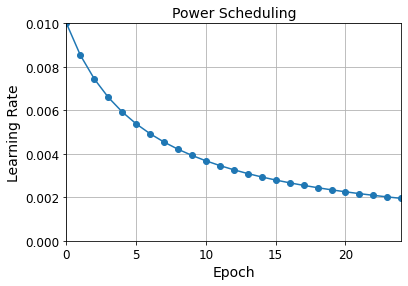

In [81]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

거듭제곱보다 더 격하게 학습률을 감소시킴. s번의 스텝마다 10배씩 감소

$\eta(t) = \eta_0 0.1^{t/s}$

In [82]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [83]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [84]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [85]:
# LearningRateScheduler는 에포크를 시작할 때마다 옵티마이저의 learning_rate 속성을 업데이트
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8096 - accuracy: 0.7658 - val_loss: 0.8873 - val_accuracy: 0.7546 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7035 - accuracy: 0.7935 - val_loss: 0.9342 - val_accuracy: 0.6770 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7317 - accuracy: 0.7927 - val_loss: 0.7864 - val_accuracy: 0.7762 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6325 - accuracy: 0.8141 - val_loss: 0.6452 - val_accuracy: 0.8296 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5398 - accuracy: 0.8417 - val_loss: 0.5472 - val_accuracy: 0.8468 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4738 - accuracy: 0.8588 - val_loss: 0.5079 - val_accuracy: 0.8598 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] 

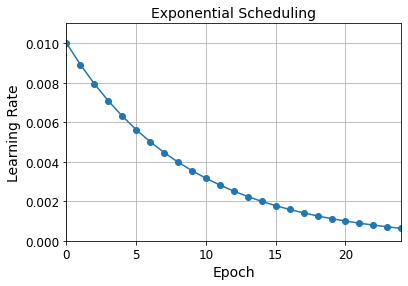

In [86]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [87]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

In [88]:
# 에포크가 아니라 반복마다 업데이트 하는 방법

K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8086 - accuracy: 0.7687 - val_loss: 0.9031 - val_accuracy: 0.7444 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.6359 - accuracy: 0.8053 - val_loss: 0.5332 - val_accuracy: 0.8392 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5603 - accuracy: 0.8239 - val_loss: 0.7664 - val_accuracy: 0.7916 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5164 - accuracy: 0.8381 - val_loss: 0.4912 - val_accuracy: 0.8382 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4866 - accuracy: 0.8491 - val_loss: 0.4599 - val_accuracy: 0.8592 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4161 - accuracy: 0.8654 - val_loss: 0.4538 - val_accuracy: 0.8598 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] 

In [89]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

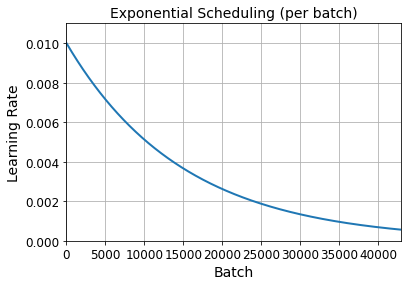

In [90]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### 구간별 고정 스케줄링

일정 횟수의 에포크 동안 일정한 학습률을 사용하고, 다음 횟수의 에포크동안 작은 학습률을 사용하는 방법

In [92]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [93]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [94]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8562 - accuracy: 0.7547 - val_loss: 1.0247 - val_accuracy: 0.7198 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.9206 - accuracy: 0.7372 - val_loss: 0.9175 - val_accuracy: 0.6928 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.9225 - accuracy: 0.7286 - val_loss: 1.1909 - val_accuracy: 0.5888 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.9599 - accuracy: 0.6910 - val_loss: 0.8778 - val_accuracy: 0.7234 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.9014 - accuracy: 0.7022 - val_loss: 0.8806 - val_accuracy: 0.7180 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6375 - accuracy: 0.7794 - val_loss: 0.6572 - val_accuracy: 0.8180 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 

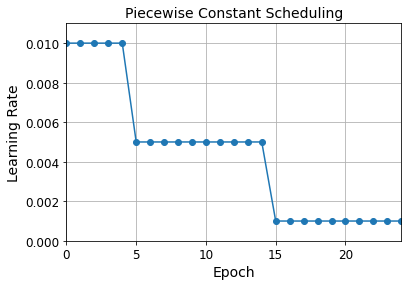

In [95]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 성능 기반 스케줄링

매 N 스텝마다 검증 오차를 측정하고 오차가 줄어들지 않으면 $\lambda$배만큼 학습률을 감소

In [96]:
tf.random.set_seed(42)
np.random.seed(42)

In [97]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5927 - accuracy: 0.8076 - val_loss: 0.4600 - val_accuracy: 0.8556 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5021 - accuracy: 0.8379 - val_loss: 0.5768 - val_accuracy: 0.8318 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5223 - accuracy: 0.8381 - val_loss: 0.5083 - val_accuracy: 0.8486 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5248 - accuracy: 0.8432 - val_loss: 0.4789 - val_accuracy: 0.8524 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5397 - accuracy: 0.8467 - val_loss: 0.6389 - val_accuracy: 0.8112 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5226 - accuracy: 0.8501 - val_loss: 0.6110 - val_accuracy: 0.8400 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 5s

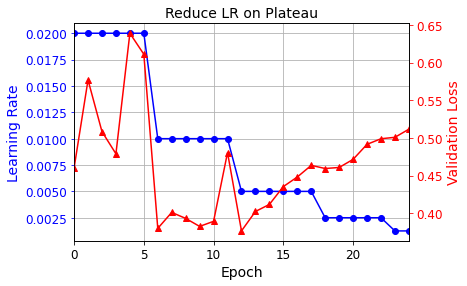

In [98]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras 스케줄러

In [99]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)      # 지수기반 스케줄링
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4894 - accuracy: 0.8275 - val_loss: 0.4094 - val_accuracy: 0.8600
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3819 - accuracy: 0.8651 - val_loss: 0.3739 - val_accuracy: 0.8696
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3486 - accuracy: 0.8765 - val_loss: 0.3728 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3264 - accuracy: 0.8837 - val_loss: 0.3492 - val_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3104 - accuracy: 0.8898 - val_loss: 0.3434 - val_accuracy: 0.8790
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2958 - accuracy: 0.8952 - val_loss: 0.3415 - val_accuracy: 0.8812
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2853 - accuracy: 0.8988 - val_loss: 0.3354 - val_accuracy:

In [100]:
# 구간별 고정 스케줄러
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1사이클 스케줄링

훈련 절반동안 초기 학습률을 선형적으로 증가시켰다가, 나머지 절반동안 다시 초기학습률까지 선형적으로 감소.

보통 최대 학습률은 최적의 학습률을 찾을 때와 같은 방식으로 찾아서 사용하고, 최소 학습률은 그 10배정도 낮은 값을 선택

In [102]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_epoch_begin(self, epoch, logs=None):
        self.prev_loss = 0
    def on_batch_end(self, batch, logs=None):
        batch_loss = logs["loss"] * (batch + 1) - self.prev_loss * batch
        self.prev_loss = logs["loss"]
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [103]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.3858


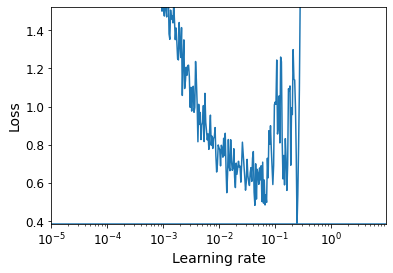

In [104]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [105]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [106]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 3s 6ms/step - loss: 0.6572 - accuracy: 0.7739 - val_loss: 0.4872 - val_accuracy: 0.8338
Epoch 2/25
430/430 [==============================] - 3s 8ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4275 - val_accuracy: 0.8520
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4122 - accuracy: 0.8546 - val_loss: 0.4116 - val_accuracy: 0.8584
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3869 - val_accuracy: 0.8684
Epoch 5/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3640 - accuracy: 0.8717 - val_loss: 0.3766 - val_accuracy: 0.8678
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3457 - accuracy: 0.8774 - val_loss: 0.3747 - val_accuracy: 0.8710
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3330 - accuracy: 0.8811 - val_loss: 0.3634 - val_accuracy: 0.8710
Epoch 

# 11.4 규제를 사용해 과대적합 피하기

## 11.4.1 $\ell_1$과 $\ell_2$ 규제

In [107]:
layer = keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(0.01))

In [108]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [110]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense, activation='elu', kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax', kernel_initializer='glorot_uniform')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 6ms/step - loss: 1.6699 - accuracy: 0.8116 - val_loss: 0.7200 - val_accuracy: 0.8324
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7182 - accuracy: 0.8276 - val_loss: 0.6826 - val_accuracy: 0.8376


## 11.4.2 드롭아웃

매 훈련 스텝에서 각 뉴런은 임시적으로 드롭아웃 될 확률 p를 가지며 해당 스텝에서 드롭아웃

In [111]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28,28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 6ms/step - loss: 0.5708 - accuracy: 0.8029 - val_loss: 0.3612 - val_accuracy: 0.8724
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4179 - accuracy: 0.8464 - val_loss: 0.3505 - val_accuracy: 0.8698


## 알파 드롭아웃

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

In [113]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6617 - accuracy: 0.7611 - val_loss: 0.5769 - val_accuracy: 0.8408
Epoch 2/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5546 - accuracy: 0.7965 - val_loss: 0.5436 - val_accuracy: 0.8468
Epoch 3/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5255 - accuracy: 0.8066 - val_loss: 0.5019 - val_accuracy: 0.8560
Epoch 4/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5048 - accuracy: 0.8130 - val_loss: 0.4768 - val_accuracy: 0.8598
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4927 - accuracy: 0.8172 - val_loss: 0.4613 - val_accuracy: 0.8602
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4837 - accuracy: 0.8205 - val_loss: 0.4834 - val_accuracy: 0.8562
Epoch 7/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4717 - accuracy: 0.8248 - val_loss: 0.5105 - val_accuracy:

In [114]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4576 - accuracy: 0.8612


[0.45764046907424927, 0.8611999750137329]

In [115]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.3326 - accuracy: 0.8837


[0.33258962631225586, 0.8837272524833679]

In [116]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 6s 3ms/step - loss: 0.4185 - accuracy: 0.8436


## 11.4.3 몬테 카를로 드롭아웃

In [117]:
tf.random.set_seed(42)
np.random.seed(42)

In [119]:
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [120]:
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 146ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [121]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.31, 0.  , 0.63]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.77, 0.  , 0.19]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.79]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.14, 0.  , 0.83]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.16, 0.  , 0.69]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.94, 0.  , 0.01, 0.  , 0.05]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.6 , 0.  , 0.25]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.93, 0.  , 0.05]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.64, 0.  , 0.33]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.23, 0.  , 0.7 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.  , 0.03, 0.  , 0.74]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.05, 0.  , 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.6 , 0.  , 0.1 , 0.  , 0.29]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.37, 0.  , 0

In [122]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.22, 0.01, 0.64]],
      dtype=float32)

In [124]:
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.  , 0.21, 0.05, 0.27]],
      dtype=float32)

In [125]:
y_pred = np.argmax(y_proba, axis=1)

In [126]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.869

In [127]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [128]:
tf.random.set_seed(42)
np.random.seed(42)

In [129]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [130]:
mc_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_265 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_266 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [131]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [132]:
mc_model.set_weights(model.get_weights())

In [133]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

1/1 [==============================] - 0s 15ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.27, 0.  , 0.63]],
      dtype=float32)

## 11.4.4 맥스-노름 규제

각 입력의 가중치의 l2 norm이 최대값(max_norm 하이퍼파라미터)를 넘지않도록 조정

In [135]:
layer = keras.layers.Dense(100, activation='elu', kernel_initializer='lecun_normal',
                          kernel_constraint=keras.constraints.max_norm(1.))

In [136]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4739 - accuracy: 0.8330 - val_loss: 0.3679 - val_accuracy: 0.8658
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3552 - accuracy: 0.8712 - val_loss: 0.3697 - val_accuracy: 0.8678


# 11.5 요약

### 일반적인 기본 DNN 설정

- 커널 초기화 : He 초기화
- 활성화 함수 : ELU
- 정규화 : 얇은 신경일 경우 없음. 깊은 신경망일 경우 배치 정규화
- 규제 : 조기 종료(필요시 L2 규제 추가)
- 옵티마이저 : 모멘텀 최적화(또는 RMSProp이나 Nadam)
- 학습률 스케줄 : 1사이클

### 자기 정규화를 위한 DNN 설정

- 커널 초기화 : 르쿤 초기화
- 활성화 함수 : SELU
- 정규화 : 없음(자기 정규화)
- 규제 : 필요하다면 알파 드롭아웃
- 옵티마이저 : 모멘텀 최적화(또는 RMSProp이나 Nadam)
- 학습률 스케줄 : 1사이클